In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from spacy.lang.en.stop_words import STOP_WORDS as stopWords
import spacy
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import datetime as dt

In [2]:
today_date = dt.datetime.today().strftime("%Y-%m-%d")

In [3]:
df = pd.read_csv(f"datasets/stock_market_news_{today_date}.csv")
print(df)

                                                 News
0   U.S. stocks mostly extended their big post-ele...
1   Domestic freight demand is not only strong, it...
2   (Bloomberg) -- China’s bond traders, who had b...
3   The latest update is out from Arhaus ( (ARHS) ...
4   As AI continues to revolutionise the medical d...
5   (Bloomberg) -- US equity futures dropped as th...
6   (Bloomberg) -- Turkey’s central bank raised it...
7   Check back for updates throughout the trading ...
8   The offers on this page are from advertisers w...
9   How do you find the right stocks to buy? It’s ...
10  New vehicle sales in Japan increased by just o...
11  (Bloomberg) -- After months of caution in the ...
12  European clean energy stocks saw a significant...
13  A majority of Big Tech stocks got a boost on W...
14  United Airlines shares are doing really well. ...
15  \nThe bond market will close for Veterans Day ...
16  (Bloomberg) -- The yuan declined while Chinese...
17  (Bloomberg) — A whopping

In [4]:
df.columns = ["text"]

In [5]:
label_w_word_df = df.copy()

In [6]:
positive_words = pd.read_csv("datasets/positive_words.csv")
neutral_words = pd.read_csv("datasets/neutral_words.csv")
negative_words = pd.read_csv("datasets/negative_words.csv")

In [7]:
positive_words["text"] = positive_words["text"].fillna("")


positive_words["text"] = positive_words["text"].apply(
    lambda x: ' '.join(word for word in x.split() if word not in set(neutral_words["text"]) | set(negative_words["text"]))
)

In [8]:
neutral_words["text"] = neutral_words["text"].fillna("")


neutral_words["text"] = neutral_words["text"].apply(
    lambda x: ' '.join(word for word in x.split() if word not in set(positive_words["text"]) | set(negative_words["text"]))
)

In [9]:
negative_words["text"] = negative_words["text"].fillna("")


negative_words["text"] = negative_words["text"].apply(
    lambda x: ' '.join(word for word in x.split() if word not in set(positive_words["text"]) | set(neutral_words["text"]))
)

In [10]:
label_w_word_df["label"] = ""

In [11]:
positive_words_set = set(positive_words["text"])
negative_words_set = set(negative_words["text"])
neutral_words_set = set(neutral_words["text"])

In [12]:
def classify_label(row):
    words = row["text"].split()
    if any(word in positive_words_set for word in words):
        return "positive"
    elif any(word in negative_words_set for word in words):
        return "negative"
    elif any(word in neutral_words_set for word in words):
        return "neutral"
    else:
        return "unknown"

In [13]:
label_w_word_df["label"] = label_w_word_df.apply(classify_label, axis=1)

In [14]:
label_w_word_df

,text,label
0,U.S. stocks mostly extended their big post-ele...,negative
1,"Domestic freight demand is not only strong, it...",unknown
2,"(Bloomberg) -- China’s bond traders, who had b...",negative
3,The latest update is out from Arhaus ( (ARHS) ...,unknown
4,As AI continues to revolutionise the medical d...,unknown
5,(Bloomberg) -- US equity futures dropped as th...,neutral
6,(Bloomberg) -- Turkey’s central bank raised it...,unknown
7,Check back for updates throughout the trading ...,unknown
8,The offers on this page are from advertisers w...,unknown
9,How do you find the right stocks to buy? It’s ...,unknown


In [15]:
df

,text
0,U.S. stocks mostly extended their big post-ele...
1,"Domestic freight demand is not only strong, it..."
2,"(Bloomberg) -- China’s bond traders, who had b..."
3,The latest update is out from Arhaus ( (ARHS) ...
4,As AI continues to revolutionise the medical d...
5,(Bloomberg) -- US equity futures dropped as th...
6,(Bloomberg) -- Turkey’s central bank raised it...
7,Check back for updates throughout the trading ...
8,The offers on this page are from advertisers w...
9,How do you find the right stocks to buy? It’s ...


In [16]:
df["text"] = df["text"].str.lower()

In [17]:
df["text"] = df["text"].apply(lambda x: re.sub(r"(?<!\d)[.,;:](?!\d)", "", x)) 
df["text"] = df["text"].apply(lambda x: re.sub(r"\b(\d+(\.\d+)?%?)\b", r"\1", x))

In [18]:
nlp = spacy.load("en_core_web_sm")

In [19]:
df["text"] = df["text"].apply(lambda x:
                               " ".join([word.text for word in nlp(x) 
                                         if word.text.lower() not in stopWords and len(word.text) > 1]))

In [20]:
df["text"] = df["text"].str.strip()

In [21]:
df["text"] = df["text"].str.replace(r"\s+", " ", regex=True)

In [22]:
text = " ".join(i for i in df.text)

In [23]:
wordCloud = WordCloud().generate(text)

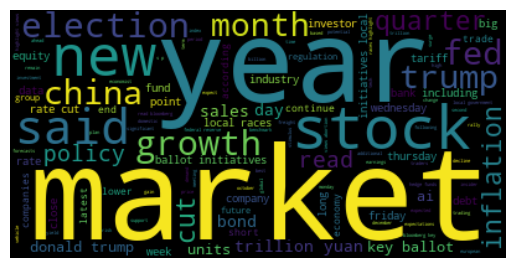

In [24]:
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
vectorizer = CountVectorizer(max_features=6000)

In [27]:
X = vectorizer.fit_transform(df["text"])

In [28]:
inertia = []
k_values = range(2,10)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

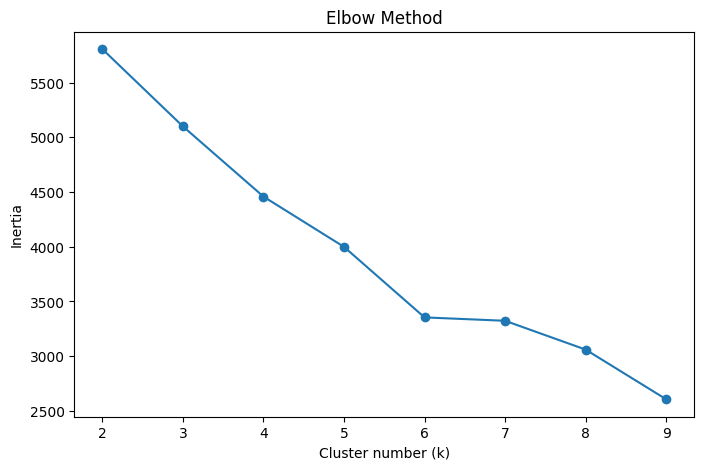

In [29]:
plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel("Cluster number (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [30]:
silhouette_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

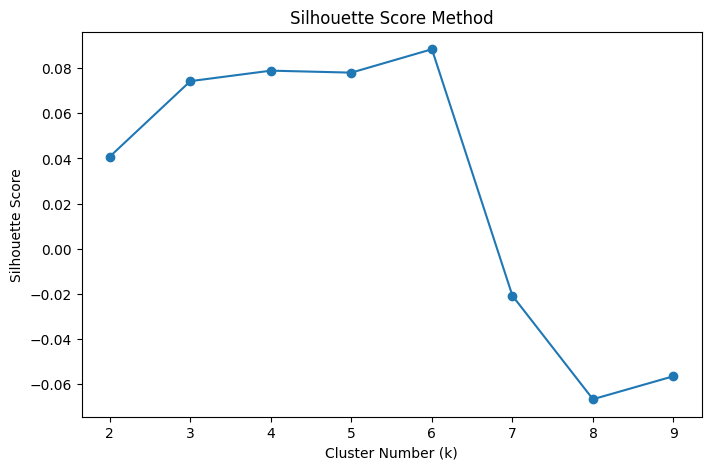

In [31]:
plt.figure(figsize=(8,5))
plt.plot(k_values, silhouette_scores, marker="o")
plt.xlabel("Cluster Number (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Method")
plt.show()

In [32]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_

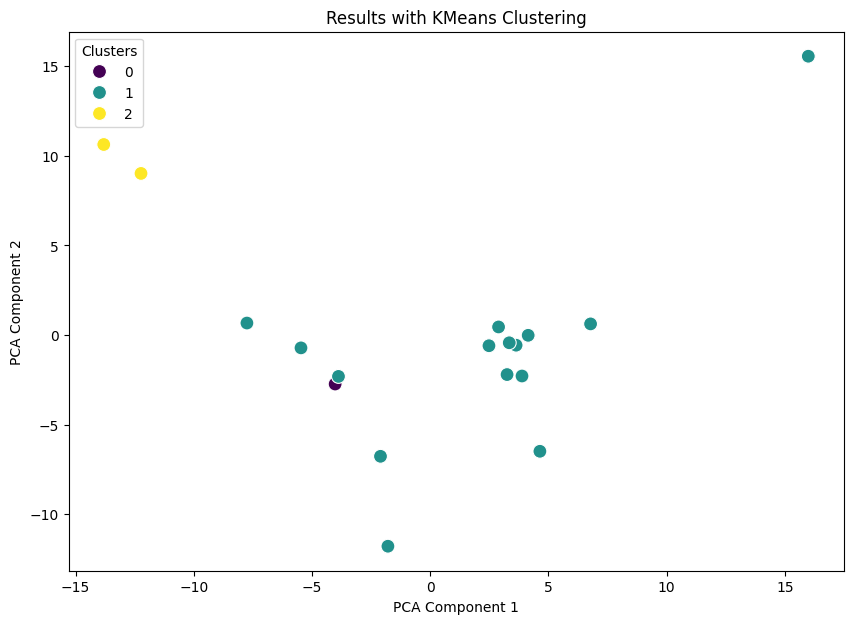

In [33]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette="viridis", s=100)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Results with KMeans Clustering")
plt.legend(title="Clusters")
plt.show()

In [34]:
clustered_data = pd.DataFrame({"text": df["text"], "label":labels})

In [35]:
for cluster in range(k):
    print(f"Cluster {cluster}:")
    print(clustered_data[clustered_data['label'] == cluster]['text'].values)
    print("\n")

Cluster 0:
['bloomberg -- turkey central bank raised inflation forecasts year 2026 bringing closer market expectations price gains exceeded estimates consecutive months read bloomberg key ballot initiatives local races highlight views abortion immigration paris restricts traffic city center housing immigration key ballot initiatives local races follow latest outlook shows officials inflation finishing year 44 reaching 21 end 2025 previous estimates 38 14 respectively revision ideal deviation bank expects price growth 38 march governor fatih karahan said friday capital ankara forecasts short term goals monetary authority tries achieve official target longer term karahan new york fed economist policy adviser appeared optimistic slowing levels domestic demand improvement services inflation particularly sticky rent prices main reason stickiness seen slowing fourth quarter said contrast inflation expectations key pillar central bank policy desired levels according governor question answer s

In [36]:
clustered_data["label_name"] = ""

In [37]:
def label_name(row):
    label = row["label"] 
    if label == 0:
        return "Neutral"
    elif label == 1:
        return "Negative"
    else:
        return "Positive"

In [38]:
clustered_data["label_name"] = clustered_data.apply(label_name, axis=1)

In [39]:
clustered_data

,text,label,label_name
0,stocks extended big post election rally thursd...,1,Negative
1,domestic freight demand strong growing stronge...,1,Negative
2,bloomberg -- china bond traders anticipating k...,2,Positive
3,latest update arhaus arhs arhaus leading lifes...,1,Negative
4,ai continues revolutionise medical device indu...,1,Negative
5,bloomberg -- equity futures dropped market gav...,1,Negative
6,bloomberg -- turkey central bank raised inflat...,0,Neutral
7,check updates trading day equity futures edged...,1,Negative
8,offers page advertisers pay influence products...,1,Negative
9,find right stocks buy simple question answer c...,1,Negative


In [40]:
clustered_data.drop(columns="label", inplace=True)

In [41]:
clustered_data.to_csv(f"datasets/clustered_{today_date}.csv", index=False)

In [42]:
label_w_word_df

,text,label
0,U.S. stocks mostly extended their big post-ele...,negative
1,"Domestic freight demand is not only strong, it...",unknown
2,"(Bloomberg) -- China’s bond traders, who had b...",negative
3,The latest update is out from Arhaus ( (ARHS) ...,unknown
4,As AI continues to revolutionise the medical d...,unknown
5,(Bloomberg) -- US equity futures dropped as th...,neutral
6,(Bloomberg) -- Turkey’s central bank raised it...,unknown
7,Check back for updates throughout the trading ...,unknown
8,The offers on this page are from advertisers w...,unknown
9,How do you find the right stocks to buy? It’s ...,unknown
